In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [41]:
# Import data

df = pd.read_csv(".//MFG10YearTerminationData.csv")

In [42]:
# look at the data

# Check size of the dataset
df.shape

(49653, 18)

In [43]:
# Data types
df.dtypes

EmployeeID              int64
recorddate_key         object
birthdate_key          object
orighiredate_key       object
terminationdate_key    object
age                     int64
length_of_service       int64
city_name              object
department_name        object
job_title              object
store_name              int64
gender_short           object
gender_full            object
termreason_desc        object
termtype_desc          object
STATUS_YEAR             int64
STATUS                 object
BUSINESS_UNIT          object
dtype: object

In [44]:
# A prelimiary look at the individual columns in the training set
df.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
0,1318,12/31/2006 0:00,1/3/1954,8/28/1989,1/1/1900,52,17,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
1,1318,12/31/2007 0:00,1/3/1954,8/28/1989,1/1/1900,53,18,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
2,1318,12/31/2008 0:00,1/3/1954,8/28/1989,1/1/1900,54,19,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE
3,1318,12/31/2009 0:00,1/3/1954,8/28/1989,1/1/1900,55,20,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2009,ACTIVE,HEADOFFICE
4,1318,12/31/2010 0:00,1/3/1954,8/28/1989,1/1/1900,56,21,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2010,ACTIVE,HEADOFFICE


In [45]:
df.tail()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
49648,8258,12/1/2015 0:00,5/28/1994,8/19/2013,12/30/2015,21,2,Valemount,Dairy,Dairy Person,34,M,Male,Layoff,Involuntary,2015,TERMINATED,STORES
49649,8264,8/1/2013 0:00,6/13/1994,8/27/2013,8/30/2013,19,0,Vancouver,Customer Service,Cashier,44,F,Female,Resignaton,Voluntary,2013,TERMINATED,STORES
49650,8279,12/1/2015 0:00,7/18/1994,9/15/2013,12/30/2015,21,2,White Rock,Customer Service,Cashier,39,F,Female,Layoff,Involuntary,2015,TERMINATED,STORES
49651,8296,12/1/2013 0:00,9/2/1994,10/9/2013,12/31/2013,19,0,Kelowna,Customer Service,Cashier,16,F,Female,Resignaton,Voluntary,2013,TERMINATED,STORES
49652,8321,12/1/2014 0:00,11/28/1994,11/24/2013,12/30/2014,20,1,Grand Forks,Customer Service,Cashier,13,F,Female,Layoff,Involuntary,2014,TERMINATED,STORES


In [46]:
# Summarise the numerical data
df.describe()

,EmployeeID,age,length_of_service,store_name,STATUS_YEAR
count,49653.000000,49653.000000,49653.000000,49653.000000,49653.000000
mean,4859.495740,42.077035,10.434596,27.297605,2010.612612
std,1826.571142,12.427257,6.325286,13.514134,2.845577
min,1318.000000,19.000000,0.000000,1.000000,2006.000000
25%,3360.000000,31.000000,5.000000,16.000000,2008.000000
50%,5031.000000,42.000000,10.000000,28.000000,2011.000000
75%,6335.000000,53.000000,15.000000,42.000000,2013.000000
max,8336.000000,65.000000,26.000000,46.000000,2015.000000


In [47]:
# Summarise the non-numerical data
df.describe(include=['O'])

,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,city_name,department_name,job_title,gender_short,gender_full,termreason_desc,termtype_desc,STATUS,BUSINESS_UNIT
count,49653,49653,49653,49653,49653,49653,49653,49653,49653,49653,49653,49653,49653
unique,130,5342,4415,1055,40,21,47,2,2,4,3,2,2
top,12/31/2013 0:00,3/23/1973,9/25/2006,1/1/1900,Vancouver,Meats,Meat Cutter,F,Female,Not Applicable,Not Applicable,ACTIVE,STORES
freq,5215,40,50,42450,11211,10269,9984,25898,25898,48168,48168,48168,49068


In [49]:
# The 47 jobs can be separated according to corporate hierarchy
# Use employee, manager, and combined executives and board 
employee = ['Meat Cutter', 'Dairy Person', 'Produce Clerk', 'Baker', 'Cashier',
            'Shelf Stocker', 'Recruiter', 'HRIS Analyst', 'Accounting Clerk',
            'Benefits Admin', 'Labor Relations Analyst', 'Accounts Receiveable Clerk',
            'Accounts Payable Clerk', 'Auditor', 'Compensation Analyst',
            'Investment Analyst', 'Systems Analyst', 'Corporate Lawyer', 'Legal Counsel']

manager = ['Customer Service Manager', 'Processed Foods Manager', 'Meats Manager',
           'Bakery Manager', 'Produce Manager', 'Store Manager', 'Trainer', 'Dairy Manager']

executive = ['Exec Assistant, Finance', 'Exec Assistant, Legal Counsel',
             'CHief Information Officer', 'CEO', 'Exec Assistant, Human Resources',
             'Exec Assistant, VP Stores']

board = ['VP Stores', 'Director, Recruitment', 'VP Human Resources', 'VP Finance',
         'Director, Accounts Receivable', 'Director, Accounting',
         'Director, Employee Records', 'Director, Accounts Payable',
         'Director, HR Technology', 'Director, Investments',
         'Director, Labor Relations', 'Director, Audit', 'Director, Training',
         'Director, Compensation']

# Check all jobs were entered into the categories
total = len(employee) + len(manager) + len(executive) + len(board)
print('Total jobs categorised:', total, 'out of 47')

Total jobs categorised: 47 out of 47


In [50]:
# Make a copy of job titles in a new column
df['Hierarchy'] = df.job_title

# Replace the job titles in Hierarchy
# The corporate hierarchy intrinsically has order from small to large, 
# so ordinal numbers may be used
df.Hierarchy = df.Hierarchy.replace(employee, 0)
df.Hierarchy = df.Hierarchy.replace(manager, 1)
df.Hierarchy = df.Hierarchy.replace(executive, 2)
df.Hierarchy = df.Hierarchy.replace(board, 3)

# Check that the replacement went to plan
df.Hierarchy.value_counts()

0    47739
1     1749
3      105
2       60
Name: Hierarchy, dtype: int64

In [51]:
# Create new categories for department names

# Look at full list of departments and frequency
df.department_name.value_counts()

Meats                     10269
Dairy                      8599
Produce                    8515
Bakery                     8381
Customer Service           7122
Processed Foods            5911
Store Management            271
Executive                   100
Recruitment                  72
HR Technology                64
Accounting                   59
Employee Records             44
Accounts Receiveable         39
Labor Relations              34
Accounts Payable             34
Training                     30
Compensation                 24
Audit                        24
Investment                   24
Information Technology       20
Legal                        17
Name: department_name, dtype: int64

In [52]:
# The departments can be separated according to whether they serve the customer
# or the business
serve_cus = ['Meats', 'Dairy', 'Produce', 'Bakery', 'Customer Service', 'Processed Foods']

serve_biz = ['Store Management', 'Executive', 'Recruitment', 'HR Technology',
             'Accounting', 'Employee Records', 'Accounts Receiveable',
             'Accounts Payable', 'Labor Relations', 'Training', 'Compensation',
             'Audit', 'Investment', 'Information Technology', 'Legal']

# Check all departments were entered into the categories
total = len(serve_cus) + len(serve_biz)
print('Total departments categorised:', total, 'out of 21')

Total departments categorised: 21 out of 21


In [53]:
# Make a copy of department names in a new column
df['Service_to'] = df.department_name

# Replace the department names in Service_to
df.Service_to = df.Service_to.replace(serve_cus, 'Customer')
df.Service_to = df.Service_to.replace(serve_biz, 'Business')

# Check the replacement went to plan
df.Service_to.value_counts()

Customer    48797
Business      856
Name: Service_to, dtype: int64

In [54]:
# Create new categories for city names

# Look at full list of cities and frequency
df.city_name.value_counts()

Vancouver           11211
Victoria             4885
Nanaimo              3876
New Westminster      3211
Kelowna              2513
Burnaby              2067
Kamloops             2061
Prince George        2048
Cranbrook            1785
Surrey               1560
Richmond             1401
Terrace              1228
Chilliwack           1167
Trail                 925
Langley               901
Vernon                898
Squamish              806
Quesnel               703
Abbotsford            681
North Vancouver       648
Fort St John          621
Williams Lake         617
West Vancouver        613
Port Coquitlam        545
Aldergrove            520
Fort Nelson           322
Nelson                317
New Westminister      254
Grand Forks           236
White Rock            231
Haney                 182
Princeton             136
Dawson Creek          129
Bella Bella           126
Ocean Falls            65
Pitt Meadows           57
Cortes Island          43
Valemount              37
Dease Lake  

In [55]:
# The cities are in Canada.
# The cities can be separated according to population size.

# The population data for 2011 was obtained from Statistics Canada
# http://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/index.cfm?Lang=E
# Used 2011 as it is the most recent before the last year of this dataset (2015)
city_pop_2011 = {'Vancouver':2313328,
                 'Victoria':344615,
                 'Nanaimo':146574,
                 'New Westminster':65976,
                 'Kelowna':179839,
                 'Burnaby':223218,
                 'Kamloops':85678,
                 'Prince George':71974,
                 'Cranbrook':19319,
                 'Surrey':468251,
                 'Richmond':190473,
                 'Terrace':11486,
                 'Chilliwack':77936,
                 'Trail':7681,
                 'Langley':25081,
                 'Vernon':38180,
                 'Squamish':17479,
                 'Quesnel':10007,
                 'Abbotsford':133497,
                 'North Vancouver':48196,
                 'Fort St John':18609,
                 'Williams Lake':10832,
                 'West Vancouver':42694,
                 'Port Coquitlam':55985,
                 'Aldergrove':12083,
                 'Fort Nelson':3561,
                 'Nelson':10230,
                 'New Westminister':65976,
                 'Grand Forks':3985,
                 'White Rock':19339,
                 'Haney':76052,
                 'Princeton':2724,
                 'Dawson Creek':11583,
                 'Bella Bella':1095,
                 'Ocean Falls':129,
                 'Pitt Meadows':17736,
                 'Cortes Island':1007,
                 'Valemount':1020,
                 'Dease Lake':58,
                 'Blue River':215}
# Population notes
# New Westminister is treated as a misspelling of New Westminster
# Used Haney in Maple Ridge, British Columbia because most of the other cities are in BC
# Used Bella Bella 1 (Indian reserve) for Bella Bella
# Used Central Coast A for Ocean Falls 
# Used Strathcona B for Cortes Island
# Used Dease Lake 9 (Indian reserve) for Dease Lake

# Check dictionary made correctly
print('Cities in dictionary:', len(city_pop_2011), 'out of 40')

Cities in dictionary: 40 out of 40


In [56]:
# Make a copy of city names
df['Pop'] = df.city_name

# Map from city name to population
df.Pop = df.Pop.map(city_pop_2011)

# Make a new column for population category
df['Pop_category'] = df.Pop

# Categorise according to population size
# >= 100,000 is City
# 10,000 to 99,999 is Rural
# < 10,000 is Remote
# Guidance from Australian Institute of Health and Welfare
# http://www.aihw.gov.au/rural-health-rrma-classification/
city_ix = (df['Pop'] >= 100000)
rural_ix = ((df['Pop'] < 100000) & (df['Pop'] >= 10000))
remote_ix = (df['Pop'] < 10000)
df.loc[city_ix, 'Pop_category'] = 'City'
df.loc[rural_ix, 'Pop_category'] = 'Rural'
df.loc[remote_ix, 'Pop_category'] = 'Remote'

# Check the replacement went to plan
df.Pop_category.value_counts()

City      28194
Rural     19542
Remote     1917
Name: Pop_category, dtype: int64

In [57]:
# As the category names are based on population size, the data could be represented
# by an ordinal category instead of a nominal category.
# Convert from nominal to ordinal 
df.Pop_category = df.Pop_category.replace('Remote', 0)
df.Pop_category = df.Pop_category.replace('Rural', 1)
df.Pop_category = df.Pop_category.replace('City', 2)

# Check the replacement went to plan
df.Pop_category.value_counts()

2    28194
1    19542
0     1917
Name: Pop_category, dtype: int64

In [58]:
# Convert STATUS from string to numerical
df.STATUS = df.STATUS.map({'ACTIVE':1, 'TERMINATED':0})

In [59]:
# Data visualisation

# Separate data to avoid one excessively overlapping the other in plots.
# One set for the terminated (out of company) and working (in company)
out_of_co = df[df.STATUS == 0]
in_co = df[df.STATUS == 1]

Text(0.5, 1.0, 'In company')

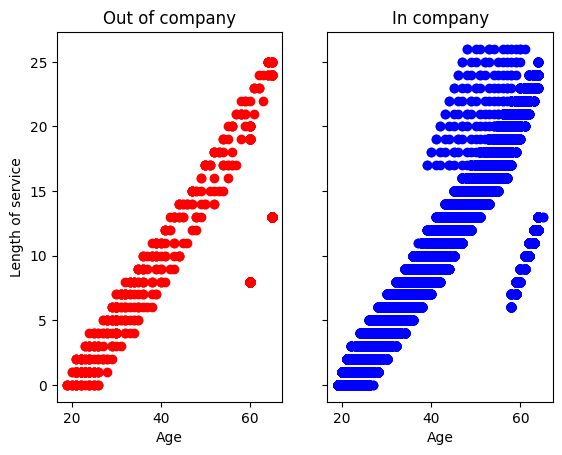

In [60]:
# Start with a broad look at each group in terms of age and length of service
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

ax1.scatter(out_of_co.age, out_of_co.length_of_service, color='r')
ax1.set_xlabel('Age')
ax1.set_ylabel('Length of service')
ax1.set_title('Out of company')

ax2.scatter(in_co.age, in_co.length_of_service, color='b')
ax2.set_xlabel('Age')
ax2.set_title('In company')

##Observations
People may leave the company after working for any length of time from 0 to 25 years and any age from 20 to 60. Take a closer look at the distribution of ages and service times for terminations.

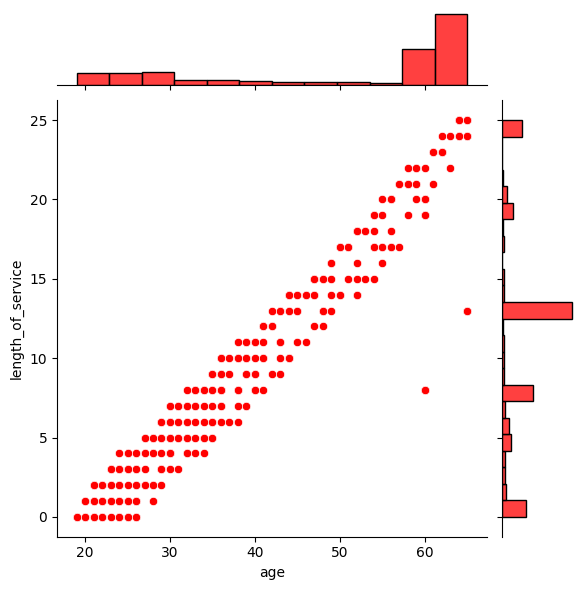

In [61]:
# Scatter plot of out of company dataset, with histograms of the axes
g = sns.jointplot(x = out_of_co.age, y = out_of_co.length_of_service, color='r')

C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


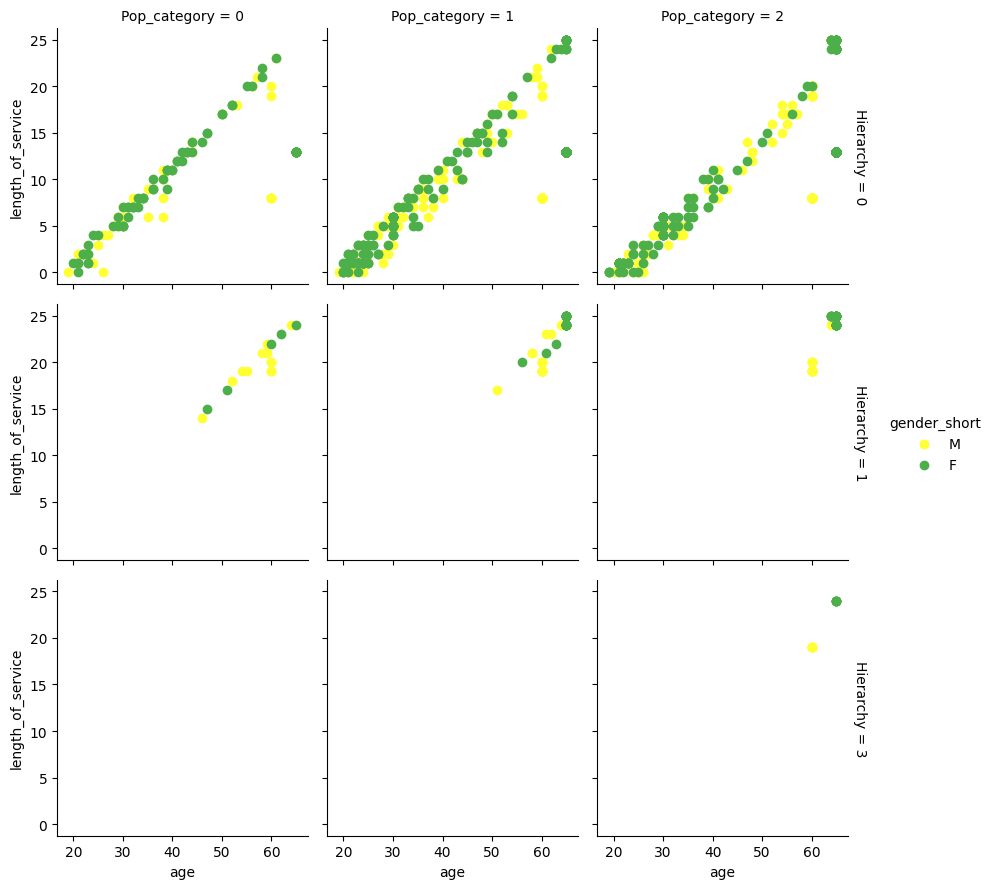

In [62]:
# When someone leaves the company, look at their age, length of service, city size,
# and position in hierarchy. Separated by gender
g = sns.FacetGrid(out_of_co, col='Pop_category', row='Hierarchy', palette='Set1_r', 
                  hue='gender_short', margin_titles=True)
g = (g.map(plt.scatter, 'age', 'length_of_service').add_legend())

C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


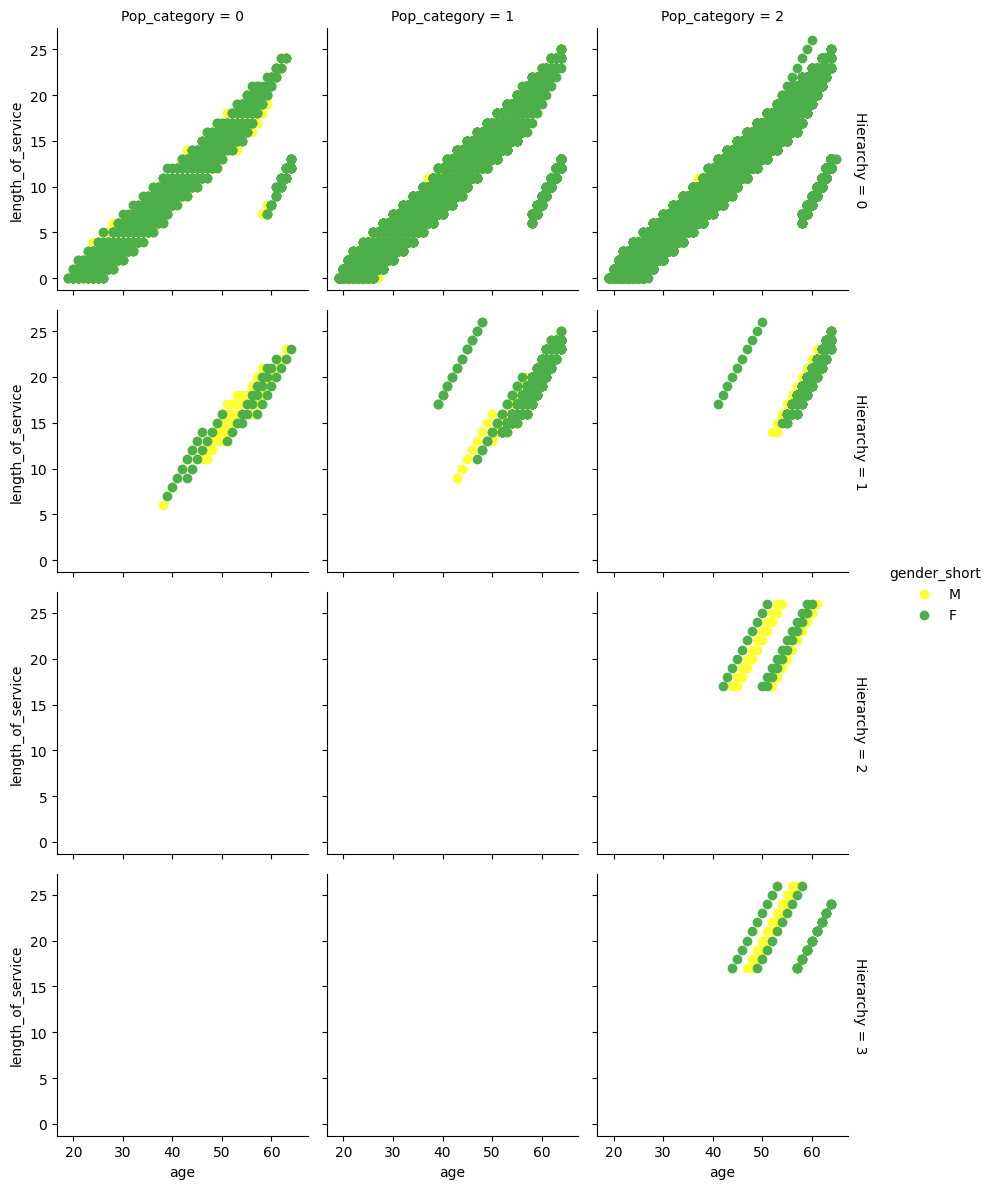

In [63]:
# Do the same for people who are working in the company
g = sns.FacetGrid(in_co, col='Pop_category', row='Hierarchy', palette='Set1_r', 
                  hue='gender_short', margin_titles=True)
g = (g.map(plt.scatter, 'age', 'length_of_service').add_legend())

C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\saran\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


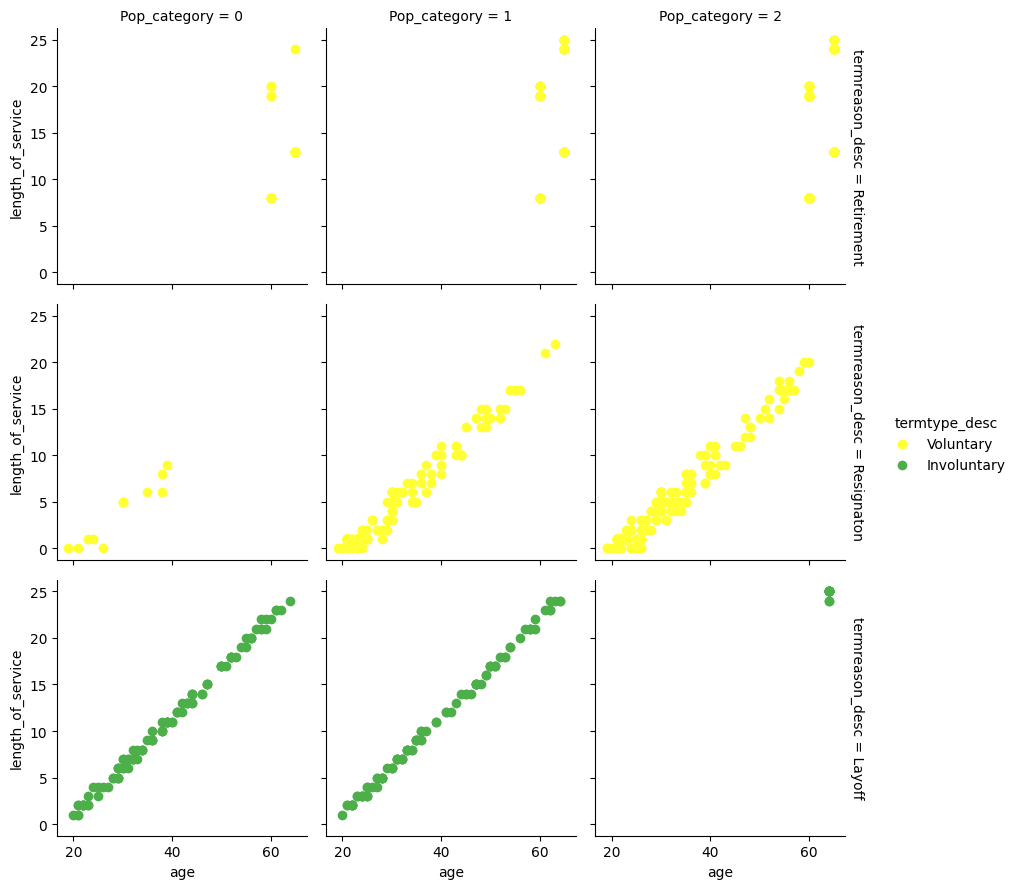

In [64]:
# Out of interest, look at when termination is voluntary or involuntary
g = sns.FacetGrid(out_of_co, col='Pop_category', row='termreason_desc', palette='Set1_r', 
                  hue='termtype_desc', margin_titles=True)
g = (g.map(plt.scatter, 'age', 'length_of_service').add_legend())

<AxesSubplot: >

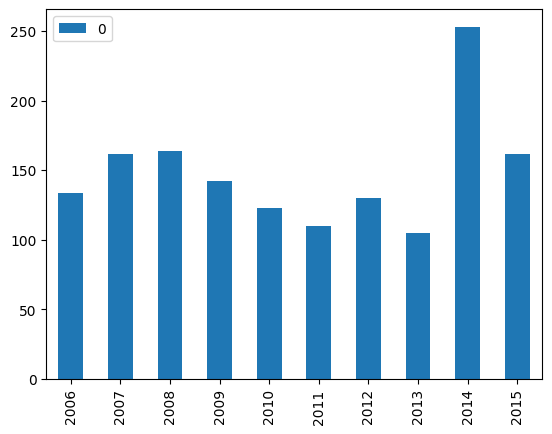

In [65]:
# Out of interest, look at number of terminations per year.
# Count terminations per year
term_per_year = Counter(out_of_co.STATUS_YEAR)
term_per_year_df = pd.DataFrame.from_dict(term_per_year, orient='index')
term_per_year_df = term_per_year_df.sort_index()
term_per_year_df.plot(kind='bar')

In [66]:
# Preprocessing for machine learning models

# Drop the employee ID, record date, birth date, termination date, termination reason, 
# termination type, gender_full, STATUS_YEAR, and store_name features
# Also drop job_title (replaced with Hierarchy), department_name (replaced with Service_to),
# and city_name and Pop (replaced with Pop_category)
drop_cols = ['EmployeeID', 'recorddate_key', 'birthdate_key', 'orighiredate_key',
             'terminationdate_key', 'gender_full', 'termreason_desc',
             'termtype_desc', 'STATUS_YEAR', 'store_name', 'job_title', 'department_name',
             'city_name', 'Pop']

df = df.drop(drop_cols, axis=1)

In [67]:
# The gender, business unit and Service_to categories are nominal, so they will
# be exploded instead of being converted to ordinal values
dummy_cols = ['gender_short', 'BUSINESS_UNIT', 'Service_to']
df = pd.get_dummies(df, columns=dummy_cols)

In [68]:
# Separate the label from the dataset
label = df.STATUS
df = df.drop('STATUS', axis=1)

In [69]:
# Split data for training and testing.
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.3,
                                                    random_state=10)

In [70]:
# KNN
model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print('KNN model score is %0.4f' %score)

KNN model score is 0.9868


In [71]:
# SVC
model = SVC(C=1, kernel='rbf', random_state=10)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print('SVC model score is %0.4f' %score)

SVC model score is 0.9704


In [72]:
# Random Forest
model = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2,
                               oob_score=False, random_state=10)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print('Random Forest model score is %0.4f' %score)

Random Forest model score is 0.9865
